In [18]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImage,
    ScaleIntensity,
    Resize,
    EnsureChannelFirst,
    RandFlip,
    RandRotate,
    SpatialCrop, # С 50% вероятностью отражает изображение по горизонтали

)
from monai.networks.nets import DenseNet121
from monai.metrics import ROCAUCMetric
from monai.handlers import CheckpointSaver, StatsHandler, TensorBoardStatsHandler
from monai.engines import SupervisedTrainer, SupervisedEvaluator

from utils import visualize_ba, visualize_distribution

In [19]:
train_df = pd.read_excel(r'train/train.xlsx', index_col=0)
# измение строк с путями
train_df['image_path'] = train_df['image_path'].str.replace('\\', '/')
train_df['annotation_path_label'] = train_df['annotation_path_label'].str.replace('\\', '/')

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 384


,ID,image_path,annotation_path_label,pathology
0,image_393.jpg,train/images/image_393.jpg,train/annotation/annotation_393.json,1
1,image_326.jpg,train/images/image_326.jpg,train/annotation/annotation_326.json,1
2,image_290.jpg,train/images/image_290.jpg,train/annotation/annotation_290.json,1
3,image_206.jpg,train/images/image_206.jpg,train/annotation/annotation_206.json,1
4,image_429.jpg,train/images/image_429.jpg,train/annotation/annotation_429.json,0


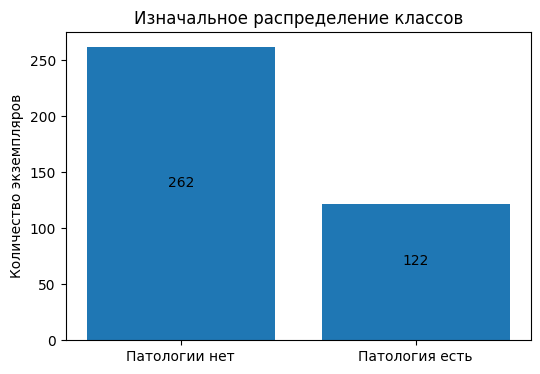

In [20]:
visualize_distribution(train_df)

In [21]:
class XRayDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        json_path = row['annotation_path_label']
        label = row['pathology']

        # Load image
        image = LoadImage()(image_path)
        
        # Load JSON annotation
        with open(json_path, 'r') as f:
            annotation = json.load(f)

        # Extract bounding box if present
        bbox = None
        if label == 1 and 'annotations' in annotation:
            bbox = annotation['annotations'][0]['bbox']

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

        return image, label, bbox

In [22]:
# Define transforms
transform = Compose([
    LoadImage(image_only=True),
    Resize((256, 256)),  # Изменение размера после обрезки
    RandFlip(spatial_axis=0, prob=0.5), # С 50% вероятностью отражает изображение по горизонтали
    RandRotate(range_x=15, prob=0.5), # C 50% вероятностью поворачивает изображение на 15 градусов
    EnsureChannelFirst(),
    ScaleIntensity(),
])

In [23]:
# Create datasets
train_dataset = XRayDataset(train_df, transforms=transform)
val_dataset = XRayDataset(train_df, transforms=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [24]:
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define model
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=1).to(device)

# Define loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Define metrics
auc_metric = ROCAUCMetric()

# Define trainer and evaluator
trainer = SupervisedTrainer(
    device=device,
    max_epochs=100,
    train_data_loader=train_loader,
    network=model,
    optimizer=optimizer,
    loss_function=loss_function,
    inferer=None,
    amp=True,
)

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=model,
    inferer=None,
    postprocessing=None,
    metrics=[auc_metric],
)

/home/gordeevae/spina_bifida/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


OptionalImportError: from ignite.engine import State (No module named 'ignite').

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

In [ ]:
# Add handlers
train_stats_handler = StatsHandler(output_transform=lambda x: x["loss"])
train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir="tensorboard_logs")
val_stats_handler = StatsHandler(output_transform=lambda x: None)
val_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir="tensorboard_logs")
checkpoint_saver = CheckpointSaver(save_dir="checkpoints", save_dict={"model": model}, save_key_metric=True)

trainer.add_event_handler(StatsHandler.OUTPUT_TRANSFORM, train_stats_handler)
trainer.add_event_handler(StatsHandler.OUTPUT_TRANSFORM, train_tensorboard_stats_handler)
evaluator.add_event_handler(StatsHandler.OUTPUT_TRANSFORM, val_stats_handler)
evaluator.add_event_handler(StatsHandler.OUTPUT_TRANSFORM, val_tensorboard_stats_handler)
evaluator.add_event_handler(StatsHandler.OUTPUT_TRANSFORM, checkpoint_saver)

In [ ]:
# Run training
trainer.run()

In [ ]:
# Evaluate the model on the validation set
eval_result = evaluator.run(val_loader)

# Print metrics
print("Validation metrics:")
for metric, value in eval_result.items():
    print(f"{metric}: {value}")

# If you want more detailed AUC information
auc_result = auc_metric.aggregate()
print(f"AUC: {auc_result}")

# You can also save these metrics to a file
with open('validation_results.txt', 'w') as f:
    f.write("Validation metrics:\n")
    for metric, value in eval_result.items():
        f.write(f"{metric}: {value}\n")
    f.write(f"AUC: {auc_result}\n")

# If you want to plot the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions and ground truth from the metric
y_pred, y_true = auc_metric.get_buffer()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()

print("Evaluation complete. Results saved to 'validation_results.txt' and ROC curve saved to 'roc_curve.png'.")